# Example Experiment
> Experiment using Repeated MNIST and BatchBALD vs BALD vs random sampling

TODO - turn off consistent MC dropout for BALD somehow...
(It's mentioned in the BatchBALD paper that whereas having consistent MC dropout
turned ON is critical for BatchBALD, having it turned OFF is critical for
BALD...this is probably where they got the idea of stochastic BALD from.)

This notebook ties everything together and runs an AL loop.

In [1]:
%load_ext autoreload
%autoreload 2

# experiment

import numpy as np
import torch
from tqdm.auto import tqdm

SEED = 51505
STRATEGY = "bald"

max_training_samples = 150  # TERMINATION CONDITION - i.e. STOP ACQUIRING ONCE WE HAVE THIS MANY
acquisition_batch_size = 5
num_inference_samples = 100  # MONTE CARLO DROPOUT ENSEMBLE SIZE FOR COMPUTING MARGINAL ENTROPY
num_test_inference_samples = 5  # ENSEMBLE SIZE FOR SCORING ON TEST SET
num_samples = 100000  # FOR BATCH BALD JOINT ENTROPY COMPUTATION... THIS IS WHY IT'S SLOW

test_batch_size = 512
batch_size = 64
scoring_batch_size = 128
training_iterations = 4096 * 6


assert STRATEGY in ["batch_bald", "bald", "random"]

np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
# experiment

import math

import torch
from torch import nn as nn
from torch.nn import functional as F

from batchbald_redux import (
    active_learning,
    batchbald,
    consistent_mc_dropout,
    joint_entropy,
    repeated_mnist,
)

Let's define our Bayesian CNN model that we will use to train MNIST.

In [3]:
# experiment


class BayesianCNN(consistent_mc_dropout.BayesianModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv1_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.fc1 = nn.Linear(1024, 128)
        self.fc1_drop = consistent_mc_dropout.ConsistentMCDropout()
        self.fc2 = nn.Linear(128, num_classes)

    def mc_forward_impl(self, input: torch.Tensor):
        input = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(input)), 2))
        input = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(input)), 2))
        input = input.view(-1, 1024)
        input = F.relu(self.fc1_drop(self.fc1(input)))
        input = self.fc2(input)
        input = F.log_softmax(input, dim=1)

        return input

Grab our dataset, we'll use Repeated-MNIST. We will acquire to samples for each class for our initial training set.

N.B. with num repetitions=1, we just have the standard MNIST dataset

In [4]:
# experiment
g = torch.Generator().manual_seed(SEED)
train_dataset, test_dataset = repeated_mnist.create_repeated_MNIST_dataset(num_repetitions=1, add_noise=False)

num_initial_samples = 20
num_classes = 10

initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset),
    num_classes=num_classes,
    n_per_digit=num_initial_samples / num_classes,
    generator=g,
)
initial_samples

[42166,
 38358,
 10065,
 48041,
 17784,
 50417,
 24155,
 40706,
 5445,
 41228,
 49514,
 33271,
 48070,
 52203,
 41623,
 1433,
 53689,
 3449,
 47520,
 9544]

In [5]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

For this example, we are going to take two shortcuts that will reduce the performance:
* we discard most of the training set and only keep 20k samples; and
* we don't implement early stopping or epoch-wise training.

Instead, we always train by drawing 24576 many samples from the training set. This will overfit in the beginning and underfit later, but it still is sufficient to achieve 90% accuracy with 105 samples in the training set. 

In [6]:
# experiment

use_cuda = torch.cuda.is_available()

print(f"use_cuda: {use_cuda}")

device = "cuda" if use_cuda else "cpu"

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(40000)

train_loader = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")

while True:
    model = BayesianCNN(num_classes).to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = model(data, 1).squeeze(1)
        loss = F.nll_loss(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = torch.logsumexp(model(data, num_test_inference_samples), dim=1) - math.log(
                num_test_inference_samples
            )
            loss += F.nll_loss(prediction, target, reduction="sum")

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire pool predictions
    N = len(active_learning_data.pool_dataset)
    
    if STRATEGY in ["batch_bald", "bald"]:
        logits_N_K_C = torch.empty((N, num_inference_samples, num_classes), dtype=torch.double, pin_memory=use_cuda)

        with torch.no_grad():
            model.eval()

            for i, (data, _) in enumerate(tqdm(pool_loader, desc="Evaluating Acquisition Set", leave=False)):
                data = data.to(device=device)

                lower = i * pool_loader.batch_size
                upper = min(lower + pool_loader.batch_size, N)
                logits_N_K_C[lower:upper].copy_(model(data, num_inference_samples).double(), non_blocking=True)

        if STRATEGY == "batch_bald":
            with torch.no_grad():
                candidate_batch = batchbald.get_batchbald_batch(
                    logits_N_K_C, acquisition_batch_size, num_samples, dtype=torch.double, device=device
                )
        elif STRATEGY == "bald":
            with torch.no_grad():
                candidate_batch = batchbald.get_bald_batch(
                    logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
                )
    elif STRATEGY == "random":
        candidate_batch = batchbald.get_random_batch(N, acquisition_batch_size)
    else:
        raise ValueError(STRATEGY)

    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

use_cuda: False


Training Set Size:  13%|#3        | 20/150 [00:00<?, ?it/s]

Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.9851, Accuracy: 6187/10000 (61.87%)


Evaluating Acquisition Set:   0%|          | 0/157 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19980 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19980 [00:00<?, ?it/s]

Dataset indices:  [18726 17428  5982 57772 34758]
Scores:  [1.4329846533152109, 1.3192958565532913, 1.2908821049522698, 1.2651638549973514, 1.2583984837030975]
Labels:  tensor([4, 4, 4, 8, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.9064, Accuracy: 6609/10000 (66.09%)


Evaluating Acquisition Set:   0%|          | 0/157 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19975 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19975 [00:00<?, ?it/s]

Dataset indices:  [54316 50319  5062 35111 59674]
Scores:  [1.281650437111583, 1.2625439896358215, 1.2372912445939481, 1.2272352889413534, 1.2098697896954766]
Labels:  tensor([6, 4, 9, 2, 4])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.6580, Accuracy: 6978/10000 (69.78%)


Evaluating Acquisition Set:   0%|          | 0/157 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19970 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19970 [00:00<?, ?it/s]

Dataset indices:  [51367 21880 34056 51972 37783]
Scores:  [1.202277202530725, 1.1825381944939262, 1.1771623359467744, 1.168845189892616, 1.1504220298887735]
Labels:  tensor([5, 2, 2, 5, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.3501, Accuracy: 6991/10000 (69.91%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19965 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19965 [00:00<?, ?it/s]

Dataset indices:  [44748  1683 11208 54577 48384]
Scores:  [1.2247012371786252, 1.2036761187700735, 1.2005057811421302, 1.1939890956964816, 1.1919497316973482]
Labels:  tensor([8, 9, 9, 5, 9])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.4899, Accuracy: 6784/10000 (67.84%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19960 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19960 [00:00<?, ?it/s]

Dataset indices:  [ 4360 12464 40070 19354 33734]
Scores:  [1.2772113221785708, 1.2192435156458068, 1.208840787993078, 1.1987336026668318, 1.1918178690997607]
Labels:  tensor([6, 7, 7, 5, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.0678, Accuracy: 7440/10000 (74.40%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19955 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19955 [00:00<?, ?it/s]

Dataset indices:  [17555 22167 59783 26084 34202]
Scores:  [1.2172365586260794, 1.1757166922340927, 1.151993538499165, 1.1416377015850632, 1.1355594851740536]
Labels:  tensor([2, 7, 1, 3, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.8564, Accuracy: 7629/10000 (76.29%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19950 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19950 [00:00<?, ?it/s]

Dataset indices:  [13187 42487 13460  5013 38256]
Scores:  [1.2783687450753742, 1.2718700928617093, 1.2554001902974667, 1.253660132919055, 1.2515844554902835]
Labels:  tensor([7, 0, 5, 2, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.6685, Accuracy: 8184/10000 (81.84%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19945 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19945 [00:00<?, ?it/s]

Dataset indices:  [42112 16692 49234 13242 50930]
Scores:  [1.1843282118008251, 1.1820928316269685, 1.1464051952427066, 1.1441444165966725, 1.122585043575091]
Labels:  tensor([8, 5, 3, 3, 0])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.6827, Accuracy: 8106/10000 (81.06%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19940 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19940 [00:00<?, ?it/s]

Dataset indices:  [22353 50827  8458 42439  4986]
Scores:  [1.2126034512260446, 1.1815050415441068, 1.1718783000164041, 1.15763199958268, 1.147558207620621]
Labels:  tensor([2, 1, 4, 2, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.6368, Accuracy: 8126/10000 (81.26%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19935 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19935 [00:00<?, ?it/s]

Dataset indices:  [ 6428 32505 28199 36783 37720]
Scores:  [1.3420978718831917, 1.164080387743671, 1.147752164114836, 1.1116219791718542, 1.1042232519889743]
Labels:  tensor([3, 3, 3, 0, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.6207, Accuracy: 8172/10000 (81.72%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19930 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19930 [00:00<?, ?it/s]

Dataset indices:  [46941 16022 46580  1276 30277]
Scores:  [1.23531831096733, 1.113538792526732, 1.1018272585872273, 1.0982471989949052, 1.0903830203175355]
Labels:  tensor([5, 8, 6, 5, 9])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4981, Accuracy: 8429/10000 (84.29%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19925 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19925 [00:00<?, ?it/s]

Dataset indices:  [20363 54994 43610 20050 49563]
Scores:  [1.090010375452764, 1.06042118805827, 1.0475108898237273, 1.0461151880571693, 1.020329044993946]
Labels:  tensor([8, 6, 0, 9, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.5554, Accuracy: 8215/10000 (82.15%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19920 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19920 [00:00<?, ?it/s]

Dataset indices:  [34672 45407 59726 40012 19169]
Scores:  [1.2020870663203018, 1.1949779788199875, 1.126448269039684, 1.1138178341149385, 1.1009951530046114]
Labels:  tensor([3, 3, 5, 8, 3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4679, Accuracy: 8526/10000 (85.26%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19915 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19915 [00:00<?, ?it/s]

Dataset indices:  [42940  6504  2034 41999 55241]
Scores:  [1.0724979006541808, 1.0545459055457282, 1.0542635297318408, 1.049772147511025, 1.0426142600388584]
Labels:  tensor([5, 5, 4, 0, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4286, Accuracy: 8723/10000 (87.23%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19910 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19910 [00:00<?, ?it/s]

Dataset indices:  [31308 28373 31638 42237  5161]
Scores:  [1.1084719106738352, 1.0721885039997694, 1.0641050889747077, 1.0566546822622351, 1.0417138065247318]
Labels:  tensor([8, 4, 2, 5, 7])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4060, Accuracy: 8832/10000 (88.32%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19905 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19905 [00:00<?, ?it/s]

Dataset indices:  [59986  3553 12903  1127 44123]
Scores:  [1.1206622911967403, 1.0577166166732628, 1.0573392058791966, 1.0407833105249598, 1.0390630264756395]
Labels:  tensor([6, 2, 9, 7, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3656, Accuracy: 8891/10000 (88.91%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19900 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19900 [00:00<?, ?it/s]

Dataset indices:  [40158 28420 49923 33048 51432]
Scores:  [1.0377691131427453, 1.0374962191089887, 1.0173723257675826, 1.0155030946426828, 1.0062469628591888]
Labels:  tensor([8, 1, 7, 1, 1])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3818, Accuracy: 8850/10000 (88.50%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19895 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19895 [00:00<?, ?it/s]

Dataset indices:  [53872  8443 14627 54032 53567]
Scores:  [1.0664522470350746, 1.0584543905899408, 1.0454200141317767, 1.0349078479795506, 1.019144341055598]
Labels:  tensor([8, 2, 9, 6, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3514, Accuracy: 8949/10000 (89.49%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19890 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19890 [00:00<?, ?it/s]

Dataset indices:  [23140 40593 13388 41108 23685]
Scores:  [1.1628641995647837, 1.0330194772900048, 1.0319819118946494, 1.0247591669427045, 0.9994209883011542]
Labels:  tensor([7, 4, 3, 0, 4])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3739, Accuracy: 8891/10000 (88.91%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19885 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19885 [00:00<?, ?it/s]

Dataset indices:  [ 7168  7833 59294 54814 35340]
Scores:  [1.2016393312576454, 1.089749702389987, 1.0663371539823556, 1.0548451165870887, 1.024074116025271]
Labels:  tensor([8, 5, 8, 4, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3827, Accuracy: 8839/10000 (88.39%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19880 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19880 [00:00<?, ?it/s]

Dataset indices:  [57810 43149  5921 18055 16922]
Scores:  [1.0773536655533074, 1.0695287973722196, 1.0618527150902946, 1.060600094507251, 1.0547106921438782]
Labels:  tensor([0, 0, 0, 0, 3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3343, Accuracy: 8972/10000 (89.72%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19875 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19875 [00:00<?, ?it/s]

Dataset indices:  [ 4165 43978 12345  5315 44032]
Scores:  [1.039966171823679, 0.9856616522301945, 0.9823152623762277, 0.9769280866859548, 0.9675961912817076]
Labels:  tensor([2, 3, 3, 3, 3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3600, Accuracy: 8923/10000 (89.23%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19870 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19870 [00:00<?, ?it/s]

Dataset indices:  [25910 14394 39818 48665 50898]
Scores:  [1.0805162762324778, 1.0540422980154762, 1.0490706662146798, 1.0458553281066125, 1.0428493831393306]
Labels:  tensor([1, 3, 1, 2, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3343, Accuracy: 9008/10000 (90.08%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19865 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19865 [00:00<?, ?it/s]

Dataset indices:  [57575 31090 46132 17521  4153]
Scores:  [1.0010653031042254, 0.9950206025797348, 0.9889685216071411, 0.9793450108439141, 0.9781984040543271]
Labels:  tensor([0, 4, 7, 3, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3211, Accuracy: 9011/10000 (90.11%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19860 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19860 [00:00<?, ?it/s]

Dataset indices:  [22083 44255  8812 18572 32776]
Scores:  [0.979688700810117, 0.9728038587762432, 0.9678770032389998, 0.9650823182780137, 0.9458367467124331]
Labels:  tensor([2, 6, 0, 0, 4])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3547, Accuracy: 8944/10000 (89.44%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19855 [00:00<?, ?it/s]

Entropy:   0%|          | 0/19855 [00:00<?, ?it/s]

Dataset indices:  [44143 46616 17507 40104 20641]
Scores:  [1.187440649270195, 1.1563485610271995, 1.067428532934275, 1.0553571129096457, 1.0505547270547262]
Labels:  tensor([2, 8, 2, 3, 9])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3087, Accuracy: 9071/10000 (90.71%)


In [9]:
test_loss = torch.stack(test_loss).tolist()

TypeError: expected Tensor as element 0 in argument 0, but got float

In [10]:
np.savez("bald_51505", test_loss=test_loss, test_accs=test_accs, added_indices=added_indices)

In [ ]:
# hide
# experiment
test_accs

[64.75,
 68.19,
 69.0,
 65.95,
 73.85,
 73.78,
 76.59,
 79.4,
 78.45,
 79.99,
 83.43,
 88.24,
 89.86,
 87.31,
 88.02,
 88.99,
 89.43,
 90.39,
 89.94,
 88.93,
 89.93,
 92.08,
 91.15,
 91.77,
 89.94,
 91.11,
 91.43]

In [ ]:
# hide
# experiment
test_loss

[tensor(1.7354, device='cuda:0'),
 tensor(1.6224, device='cuda:0'),
 tensor(1.5370, device='cuda:0'),
 tensor(1.6557, device='cuda:0'),
 tensor(1.2134, device='cuda:0'),
 tensor(1.2532, device='cuda:0'),
 tensor(1.0284, device='cuda:0'),
 tensor(0.9561, device='cuda:0'),
 tensor(1.0075, device='cuda:0'),
 tensor(0.8437, device='cuda:0'),
 tensor(0.6996, device='cuda:0'),
 tensor(0.4628, device='cuda:0'),
 tensor(0.3793, device='cuda:0'),
 tensor(0.4368, device='cuda:0'),
 tensor(0.4417, device='cuda:0'),
 tensor(0.4158, device='cuda:0'),
 tensor(0.3878, device='cuda:0'),
 tensor(0.3673, device='cuda:0'),
 tensor(0.3998, device='cuda:0'),
 tensor(0.3837, device='cuda:0'),
 tensor(0.3500, device='cuda:0'),
 tensor(0.2903, device='cuda:0'),
 tensor(0.3312, device='cuda:0'),
 tensor(0.3256, device='cuda:0'),
 tensor(0.3435, device='cuda:0'),
 tensor(0.3339, device='cuda:0'),
 tensor(0.3222, device='cuda:0')]

In [ ]:
# hide
# experiment
added_indices

[array([42168, 23071, 56348, 40547, 47690]),
 array([56464, 47674, 19187, 51367, 19298]),
 array([45073, 36984, 44267, 52314, 29681]),
 array([  729, 28305, 28838, 22083,  5175]),
 array([58829, 37974, 20867, 50764, 34142]),
 array([24533, 33099, 31781, 28525, 39266]),
 array([12186,  7917, 36587, 23434, 57419]),
 array([ 2765, 28599, 13371, 31512, 52035]),
 array([31981, 43609, 28512, 54038, 28856]),
 array([57632, 25332, 13096, 56300, 55241]),
 array([ 1549, 15250, 54946, 10265, 10086]),
 array([52771, 16756, 19089,  1722, 35232]),
 array([ 6428, 59294,  3810, 55388,  8447]),
 array([34520, 27458, 13021, 47936,  3056]),
 array([53260, 36152, 45069, 41933, 17494]),
 array([23112, 41572, 42703, 24740, 22662]),
 array([43716, 57714, 24526, 43796, 43686]),
 array([42020, 13969, 15848, 55393, 52083]),
 array([58874, 10481, 26072, 50632, 41495]),
 array([31063,  9633, 57507, 27429, 24426]),
 array([37469, 30157, 52708, 26622, 34481]),
 array([ 7851, 47322, 18003, 39593, 16022]),
 array([ 7

In [ ]:
# hide
test_accs = [
    64.75,
    68.19,
    69.0,
    65.95,
    73.85,
    73.78,
    76.59,
    79.4,
    78.45,
    79.99,
    83.43,
    88.24,
    89.86,
    87.31,
    88.02,
    88.99,
    89.43,
    90.39,
    89.94,
    88.93,
    89.93,
    92.08,
    91.15,
    91.77,
    89.94,
    91.11,
    91.43,
]
max_training_samples = 150
acquisition_batch_size = 5
num_inference_samples = 100
num_test_inference_samples = 5
num_samples = 100000
num_initial_samples = 20
num_classes = 10

In [ ]:
# hide
# experiment
!pip install matplotlib

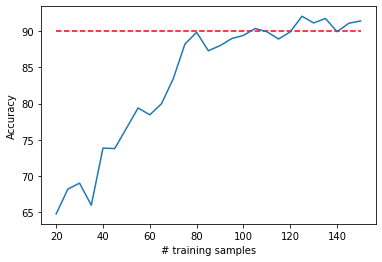

In [ ]:
# experiment
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs)
plt.xlabel("# training samples")
plt.ylabel("Accuracy")
plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.show()